In [1]:
import numpy as np
from scipy import signal, interpolate
import quaternion
import itertools

import matplotlib.pyplot as plt

from copy import copy


import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
plt.rcParams['axes.formatter.useoffset'] = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from test_imu_algorithms import IMU_test_data

Set up test data from 0 to 50 seconds at 200Hz

In [12]:
pitchvals = [0, 5, 15]        # degrees of pitch
accelvals = [0, 0.05, 0.1, 0.2]     # gs of forward-backward acceleration
frequencies = [0.1, 1, 2, 4]     # Hz
phaseoff = [0, 0.2, 0.5]      # fractional phase offset between pitch and acceleration
chip_orient = [(-85, 82, 0)]       # initial roll, pitch, yaw of chip

nvals = [len(pitchvals), len(ampvals), len(frequencies), len(phaseoff), len(chip_orient)]

All combinations of the parameters, but same noise settings

In [13]:
imus = []
params = []
ampvals = []
for p, a, f, d, o in itertools.product(pitchvals, accelvals, frequencies, phaseoff, chip_orient):
    # print "pitch {}, accel {}, freq {}, delta {}, orient {}".format(p,a,f,d,o)
    amp = 9.81 * a / (2*np.pi*f)**2
    
    imu1 = IMU_test_data((0, 50, 1.0/200))
    R0 = imu1._eul2rotm(o)
    imu1.set_initial_orientation(R0)
    
    imu1.set_noise_params(gyrorms=1.0,          # deg/sec
                     gyrofreq=20.0,        # Hz
                     gyrodriftrms=0.0,     # deg/sec
                     gyrodriftfreq=0.1,    # Hz
                     accrms=0.03,          # g
                     accfreq=33)           # Hz
    imu1.generate_arm_data(alpham=np.deg2rad(p), # pitch angle
                      Am=a, # back and forth amplitude
                      f=f, # oscillation frequency
                      l=0,    # arm length
                      delta=d) # phase lag between angle and forward back motion
    
    imus.append(imu1)
    params.append((p,a,f,d,o))
    ampvals.append(amp)

In [15]:
def get_error(imu):
    oerr = np.sqrt(np.mean(np.square(imu.orient_world - imu.orient_world_true), axis=0))
    aerr = np.sqrt(np.mean(np.square(imu.accdyn_world - imu.accdyn_world_true), axis=0))
    
    return oerr, aerr

In [16]:
orient = []
accdyn = []
orient_err = []
acc_err = []

for i, imu1 in enumerate(imus):
    # EKF
    imu1.filter(nsamp=10, method='running')

    imu1.calibrate(duration=30.0)
    imu1.get_inertial_coords(duration=30.0)
    imu1.get_world_coordinates(duration=30.0)
    
    imu1.get_orientation(method='dsf', Ca=(0.0, 0.0, 0.0))
    orient1 = copy(imu1.orient_world)
    accdyn1 = copy(imu1.accdyn_world)

    oerr1, aerr1 = get_error(imu1)
    
    # Madgwick
    imu1.filter(method='butter', order=5, gyro_cutoff=(0.1, 10), acc_cutoff=(0, 30))
    imu1.get_orientation(method='madgwick')
    orient2 = copy(imu1.orient_world)
    accdyn2 = copy(imu1.accdyn_world)
    
    oerr2, aerr2 = get_error(imu1)

    orient.append([orient1, orient2])
    accdyn.append([accdyn1, accdyn2])
    orient_err.append([oerr1, oerr2])
    acc_err.append([aerr1, aerr2])
    print "{} of {} ({}%)".format(i+1, len(imus), round(float(i+1)/len(imus)*100))

dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


1 of 144 (1.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


2 of 144 (1.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


3 of 144 (2.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


4 of 144 (3.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


5 of 144 (3.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


6 of 144 (4.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


7 of 144 (5.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


8 of 144 (6.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


9 of 144 (6.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


10 of 144 (7.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


11 of 144 (8.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


12 of 144 (8.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


13 of 144 (9.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


14 of 144 (10.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


15 of 144 (10.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


16 of 144 (11.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


17 of 144 (12.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


18 of 144 (13.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


19 of 144 (13.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


20 of 144 (14.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


21 of 144 (15.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


22 of 144 (15.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


23 of 144 (16.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


24 of 144 (17.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


25 of 144 (17.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


26 of 144 (18.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


27 of 144 (19.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


28 of 144 (19.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


29 of 144 (20.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


30 of 144 (21.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


31 of 144 (22.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


32 of 144 (22.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


33 of 144 (23.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


34 of 144 (24.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


35 of 144 (24.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


36 of 144 (25.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


37 of 144 (26.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


38 of 144 (26.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


39 of 144 (27.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


40 of 144 (28.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


41 of 144 (28.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


42 of 144 (29.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


43 of 144 (30.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


44 of 144 (31.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


45 of 144 (31.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


46 of 144 (32.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


47 of 144 (33.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


48 of 144 (33.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


49 of 144 (34.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


50 of 144 (35.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


51 of 144 (35.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


52 of 144 (36.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


53 of 144 (37.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


54 of 144 (38.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


55 of 144 (38.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


56 of 144 (39.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


57 of 144 (40.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


58 of 144 (40.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


59 of 144 (41.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


60 of 144 (42.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


61 of 144 (42.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


62 of 144 (43.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


63 of 144 (44.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


64 of 144 (44.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


65 of 144 (45.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


66 of 144 (46.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


67 of 144 (47.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


68 of 144 (47.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


69 of 144 (48.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


70 of 144 (49.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


71 of 144 (49.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


72 of 144 (50.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


73 of 144 (51.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


74 of 144 (51.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


75 of 144 (52.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


76 of 144 (53.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


77 of 144 (53.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


78 of 144 (54.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


79 of 144 (55.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


80 of 144 (56.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


81 of 144 (56.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


82 of 144 (57.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


83 of 144 (58.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


84 of 144 (58.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


85 of 144 (59.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


86 of 144 (60.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


87 of 144 (60.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


88 of 144 (61.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


89 of 144 (62.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


90 of 144 (63.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


91 of 144 (63.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


92 of 144 (64.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


93 of 144 (65.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


94 of 144 (65.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


95 of 144 (66.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


96 of 144 (67.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


97 of 144 (67.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


98 of 144 (68.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


99 of 144 (69.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


100 of 144 (69.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


101 of 144 (70.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


102 of 144 (71.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


103 of 144 (72.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


104 of 144 (72.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


105 of 144 (73.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


106 of 144 (74.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


107 of 144 (74.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


108 of 144 (75.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


109 of 144 (76.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


110 of 144 (76.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


111 of 144 (77.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


112 of 144 (78.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


113 of 144 (78.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


114 of 144 (79.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


115 of 144 (80.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


116 of 144 (81.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


117 of 144 (81.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


118 of 144 (82.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


119 of 144 (83.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


120 of 144 (83.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


121 of 144 (84.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


122 of 144 (85.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


123 of 144 (85.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


124 of 144 (86.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


125 of 144 (87.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


126 of 144 (88.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


127 of 144 (88.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


128 of 144 (89.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


129 of 144 (90.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


130 of 144 (90.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


131 of 144 (91.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


132 of 144 (92.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


133 of 144 (92.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


134 of 144 (93.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


135 of 144 (94.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


136 of 144 (94.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


137 of 144 (95.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


138 of 144 (96.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


139 of 144 (97.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


140 of 144 (97.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


141 of 144 (98.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


142 of 144 (99.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


143 of 144 (99.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


144 of 144 (100.0%)


In [17]:
orient_err = np.array(orient_err)
acc_err = np.array(acc_err)

In [18]:
total_orient_err = np.sum(orient_err, axis=2)
total_acc_err = np.sum(acc_err, axis=2)

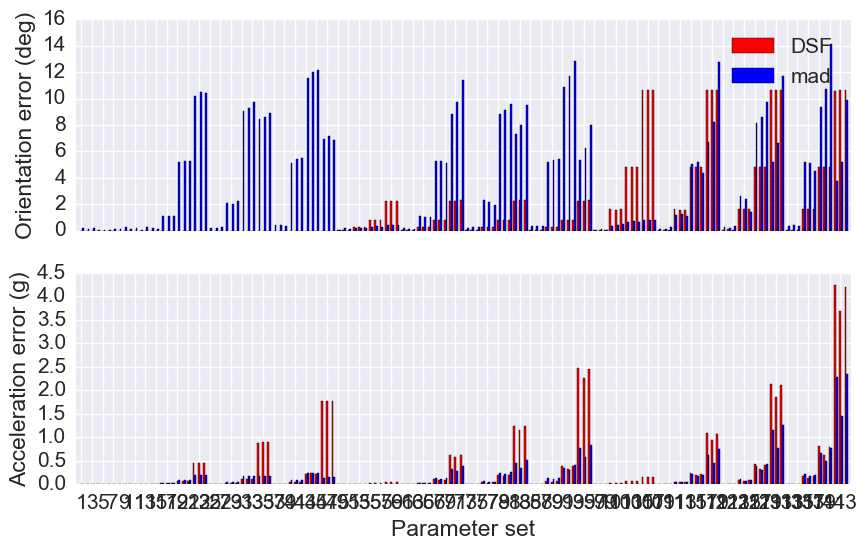

In [19]:
fig, ax = plt.subplots(2,1, sharex=True)

width = 0.35

ind = np.arange(len(imus))+1
ax[0].bar(ind-width/2, np.rad2deg(total_orient_err[:,0]), width=width, color='r', label='DSF')
ax[0].bar(ind+width/2, np.rad2deg(total_orient_err[:,1]), width=width, color='b', label='mad')
ax[0].set_ylabel('Orientation error (deg)')
ax[0].legend()

ax[1].bar(ind-width/2, total_acc_err[:,0], width=width, color='r', label='DSF')
ax[1].bar(ind+width/2, total_acc_err[:,1], width=width, color='b', label='mad')
ax[1].set_ylabel('Acceleration error (g)')

ax[1].set_xlabel('Parameter set')
ax[1].set_xticks(ind[::2])
ax[1].set_xlim([0, len(imus)+1])

plt.show()

In [20]:
true_ang_mag = []
true_acc_mag = []
for imu1 in imus:
    ang1 = np.amax(imu1.orient_world_true, axis=None) - np.amin(imu1.orient_world_true, axis=None)
    true_ang_mag.append(ang1)
    acc1 = np.amax(imu1.accdyn_world_true, axis=None) - np.amin(imu1.accdyn_world_true, axis=None)
    true_acc_mag.append(acc1)

true_ang_mag = np.array(true_ang_mag)
true_acc_mag = np.array(true_acc_mag)

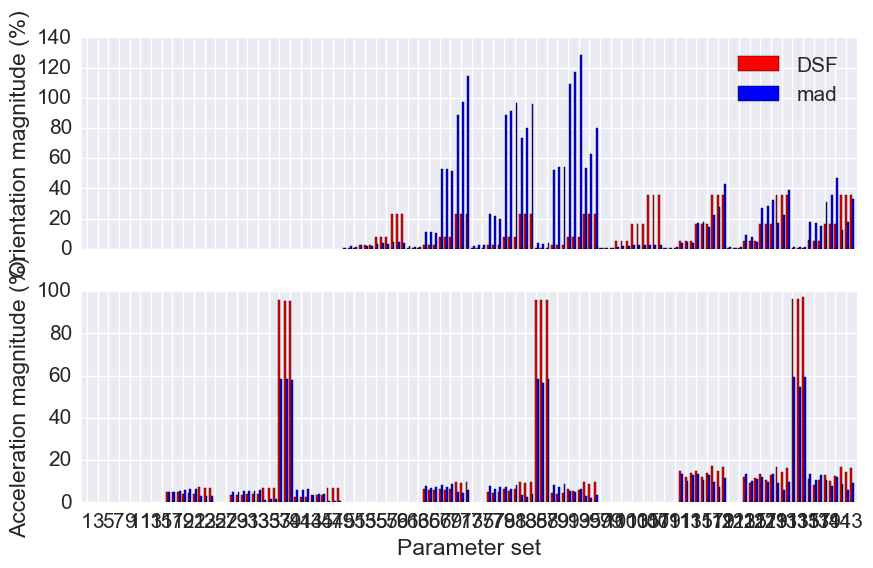

In [22]:
fig, ax = plt.subplots(2,1, sharex=True)

width = 0.35

orient_err_perc = total_orient_err / true_ang_mag[:, np.newaxis]
orient_err_perc[true_ang_mag < 0.02, :] = np.nan

acc_err_perc = total_acc_err / true_acc_mag[:, np.newaxis]
acc_err_perc[true_acc_mag < 0.01, :] = np.nan

ind = np.arange(len(imus))+1
ax[0].bar(ind-width/2, orient_err_perc[:,0]*100, width=width, color='r', label='DSF')
ax[0].bar(ind+width/2, orient_err_perc[:,1]*100, width=width, color='b', label='mad')

ax[0].set_ylabel('Orientation magnitude (%)')
ax[0].legend()

ax[1].bar(ind-width/2, acc_err_perc[:,0]*100, width=width, color='r', label='DSF')
ax[1].bar(ind+width/2, acc_err_perc[:,1]*100, width=width, color='b', label='mad')
ax[1].set_ylabel('Acceleration magnitude (%)')

ax[1].set_xlabel('Parameter set')
ax[1].set_xticks(ind[::2])
ax[1].set_xlim([0, len(imus)+1])

plt.show()

In [33]:
pitch = np.array([p[0] for p in params])
accel = np.array([p[1] for p in params])
freq = np.array([p[2] for p in params])
phaseoff = np.array([p[3] for p in params])

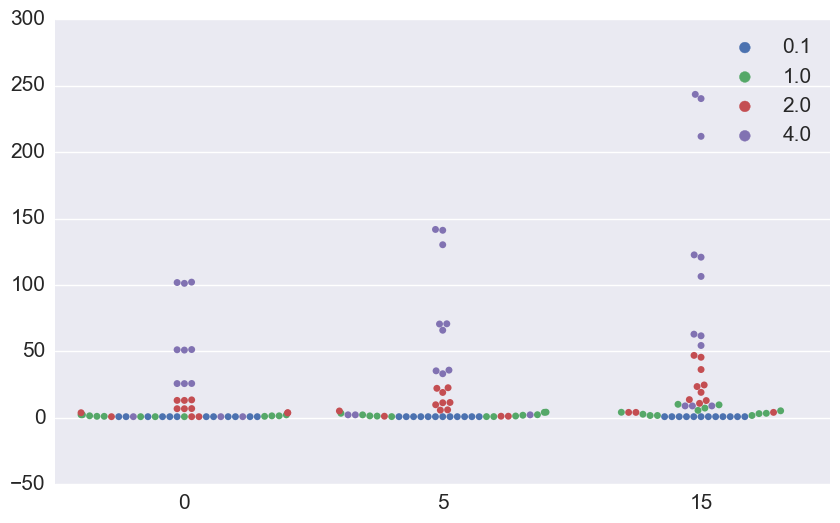

In [44]:
sns.swarmplot(x=pitch, y=np.rad2deg(total_acc_err[:,0]), hue=freq)
# sns.swarmplot(x=pitch, y=np.rad2deg(total_orient_err[:,1]), hue=accel)